[![Open In nbviewer](https://img.shields.io/badge/Jupyter-nbviewer-orange?logo=jupyter)](
https://nbviewer.org/github/RadyaSRN/sentiment-analysis-RuSentNE-2023/blob/main/notebooks/sentiment_analysis.ipynb)
[![Open In Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](
https://www.kaggle.com/kernels/welcome?src=https://github.com/RadyaSRN/sentiment-analysis-RuSentNE-2023/blob/main/notebooks/sentiment_analysis.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/RadyaSRN/sentiment-analysis-RuSentNE-2023/blob/main/notebooks/sentiment_analysis.ipynb)
[![W&B Report](https://img.shields.io/badge/Weights%20&%20Biases-Report-orange?logo=weightsandbiases)](
https://wandb.ai/radyasrn-mipt/NLP-spring-2025/reports/sentiment-analysis-RuSentNE-2023--VmlldzoxMjc3ODUyMw)

<b><font size=6>**Introduction**</font></b>

The notebook is divided into steps:

- [Step 1: Baseline RuBERT Model](#step-1-baseline-rubert-model)
- [Step 2: RuBERT Model with MLM Pretrain](#step-2-rubert-model-with-mlm-pretrain)
- [Step 3: RuBERT Model with Entity Tokens Pooling](#step-3-rubert-model-with-entity-tokens-pooling)
- [Step 4: Final Comparison of Models](#step-4-final-comparison-of-models)

This notebook presents a pipeline for training of the **[RuBERT](https://huggingface.co/DeepPavlov/rubert-base-cased) model**, its modifications, and using various techniques for sentiment analysis of the data from the **[RuSentNE-2023](https://github.com/dialogue-evaluation/RuSentNE-evaluation) competition**.

The task in the competititon was to predict the sentiment of a sentence in relation to an entity from that sentence:

![Illustration](../images/illustration.png)

The project was carried out in a Kaggle environment with a P100 GPU.

Let's make the necessary imports:

In [ ]:
import numpy as np
import os
import pandas as pd
import torch
import wandb
from datasets import Dataset
from safetensors.torch import load_file
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from transformers import (
    AutoModel,
    AutoModelForMaskedLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)
from tqdm.notebook import tqdm

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style="whitegrid")

# Models and utils
from src.models import BertEntitySentimentClassifier
from src.utils import mark_entity, compute_metrics, plot_wandb_metrics, analyze_predictions

<a name="step-1-baseline-rubert-model"></a>
<b><font size=4>**Step $1$</font></b> <b><font size=2>(Baseline RuBERT Model):**</font></b>

In this step, we will take a model with a good general understanding of the language, `DeepPavlov/rubert-base-cased`, as our initial baseline and train it on our data. We will feed the model data along with special tokens `[ENTITY]` and `[/ENTITY]` around the entity being discussed in the sentence.

Let's load the data:

In [ ]:
train_df = pd.read_csv("/kaggle/input/nlp-spring-2025-sentiment-analysis-train-val-data/train_data.csv", sep="\t")
val_df = pd.read_csv("/kaggle/input/nlp-spring-2025-sentiment-analysis-train-val-data/validation_data_labeled.csv", sep="\t")

Let's convert the labels: `-1 -> 0`, `0 -> 1`, `1 -> 2`. That is, now `0 is negative`, `1 is neutral`, `2 is positive`:

In [ ]:
label_map = {-1: 0, 0: 1, 1: 2}
train_df["label"] = train_df["label"].map(label_map)
val_df["label"] = val_df["label"].map(label_map)

Let's add special tokens:

In [ ]:
special_tokens_dict = {'additional_special_tokens': ['[ENTITY]', '[/ENTITY]']}
model_checkpoint = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

2

Let's perform the transformation using a function that adds a token responsible for the entity:

In [ ]:
train_df["input_text"] = train_df.apply(mark_entity, axis=1)
val_df["input_text"] = val_df.apply(mark_entity, axis=1)

Then we will create datasets:

In [ ]:
train_dataset = Dataset.from_pandas(train_df[["input_text", "label"]])
val_dataset = Dataset.from_pandas(val_df[["input_text", "label"]])

def tokenize(example):
    return tokenizer(example["input_text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize).remove_columns(["input_text"])
val_dataset = val_dataset.map(tokenize).remove_columns(["input_text"])
train_dataset.set_format("torch")
val_dataset.set_format("torch")

Map:   0%|          | 0/6637 [00:00<?, ? examples/s]

Map:   0%|          | 0/2845 [00:00<?, ? examples/s]

Now let's login in to `wandb`:

In [ ]:
wandb.login(key='', relogin=True)
wandb.finish()

We will train the model for 8 epochs with `learning_rate=2e-5, weight_decay=0.01`, which will most likely be sufficient for convergence:

In [ ]:
wandb.init(project="NLP-spring-2025", name="rubert-baseline-run-3")

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)
model.resize_token_embeddings(len(tokenizer))

training_args = TrainingArguments(
    output_dir="./results-rubert-baseline",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    metric_for_best_model="f1_macro_filtered",
    greater_is_better=True,
    load_best_model_at_end=True,
    report_to="wandb"
)

torch.set_float32_matmul_precision('medium')
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/tmp/ipykernel_31/3028007560.py:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,F1 Negative,F1 Positive,F1 Macro Filtered
1,0.750200,0.639895,0.647619,0.199005,0.423312
2,0.559100,0.542225,0.615385,0.609881,0.612633
3,0.428300,0.493704,0.744063,0.675722,0.709892
4,0.338000,0.512804,0.751625,0.615385,0.683505
5,0.255100,0.540111,0.748353,0.610108,0.679231
6,0.192600,0.568656,0.760925,0.636204,0.698565
7,0.156700,0.592044,0.768448,0.674576,0.721512
8,0.140400,0.593671,0.759331,0.637324,0.698327


TrainOutput(global_step=416, training_loss=0.34396454519950426, metrics={'train_runtime': 716.1144, 'train_samples_per_second': 74.145, 'train_steps_per_second': 0.581, 'total_flos': 3492567506921472.0, 'train_loss': 0.34396454519950426, 'epoch': 8.0})

Then we will finish the run:

In [ ]:
wandb.finish()

eval/f1_macro_filtered,▁▅█▇▇▇█▇
eval/f1_negative,▂▁▇▇▇███
eval/f1_positive,▁▇█▇▇▇█▇
eval/loss,█▃▁▂▃▅▆▆
eval/runtime,▁█▇█▆▇▆▆
eval/samples_per_second,█▁▂▁▃▂▃▃
eval/steps_per_second,█▁▂▁▃▂▃▃
train/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇███
train/global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇███
train/grad_norm,▁▄▄▅▆█▇▆
train/learning_rate,█▇▆▅▄▃▂▁


Then we will save the model:

In [ ]:
trainer.save_model("./rubert-baseline-model")
tokenizer.save_pretrained("./rubert-baseline-model")

('./rubert-baseline-model/tokenizer_config.json',
 './rubert-baseline-model/special_tokens_map.json',
 './rubert-baseline-model/vocab.txt',
 './rubert-baseline-model/added_tokens.json',
 './rubert-baseline-model/tokenizer.json')

Now let's look at the results:

/tmp/ipykernel_31/3774981854.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  history = history.fillna(method='ffill').fillna(method='bfill')


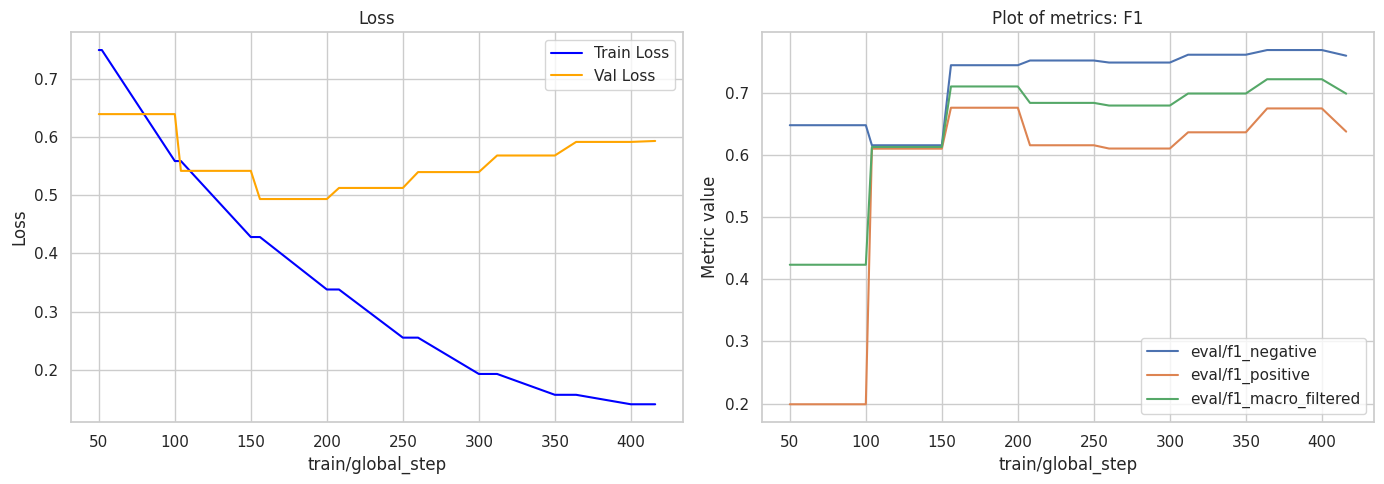

In [ ]:
plot_wandb_metrics(
    run_path='radyasrn-mipt/NLP-spring-2025/6olz7jmw',
    metric_keys=['eval/f1_negative', 'eval/f1_positive', 'eval/f1_macro_filtered'],
    title_suffix='F1'
)

Let's also look at examples of correct and incorrect predictions:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "./rubert-baseline-model", num_labels=3
)
model.resize_token_embeddings(len(tokenizer))

metrics_baseline = analyze_predictions(
    model=model,
    dataset=val_dataset,
    raw_df=val_df,
    text_column="sentence",
    label_column="label",
    entity_column="entity",
    batch_size=64,
    n_examples=5
)
metrics_baseline

  0%|          | 0/45 [00:00<?, ?it/s]


Correct predictions:
- Text: The Telegraph сообщает, что до конца сезона команду возглавит Гус Хиддинк.
  Entity: Гус Хиддинк
  True label: 2, Prediction: 2

- Text: Власти Нигера приняли решение об отзыве своего посла из Катара в знак солидарности с арабскими странами, которые разорвали дипломатические отношения с эмиратом.
  Entity: арабскими
  True label: 2, Prediction: 2

- Text: К концу войны «Голос Америки» вещал на 40 языках, а программы состояли из музыки, новостей и аналитических комментариев.
  Entity: Голос Америки
  True label: 2, Prediction: 2

- Text: Организаторами экспозиции являются отделение испанского банка ''La Caixa'' — ''Obra Social La Caixa'', шотландская компания ''Nomad Exhibitions'' и ''Museo de Nankin'', чьи старания позволили выставке путешествовать по миру.
  Entity: La Caixa
  True label: 2, Prediction: 2

- Text: Россия и Китай предложили резолюцию по Северной Корее
  Entity: Россия
  True label: 2, Prediction: 2


Wrong predictions:
- Text: Тем временем

/tmp/ipykernel_31/3206778358.py:45: RuntimeWarning: invalid value encountered in cast
  labels_np = labels.numpy().astype(int)


{'f1_negative': 0.0,
 'f1_positive': 0.10392902408111532,
 'f1_macro_filtered': 0.05196451204055766}

We can see that the cases where the model is wrong are not entirely trivial. In addition, it is good that there is no significant difference between F1 for different classes.

<a name="step-2-rubert-model-with-mlm-pretrain"></a>
<b><font size=4>**Step $2$</font></b> <b><font size=2>(RuBERT Model with MLM Pretrain):**</font></b>

In this step, we will try a model with the same architecture as the baseline, but before training on the main task, it goes through a masked language modeling pre-training stage.

Let's create datasets:

In [ ]:
mlm_train_dataset = Dataset.from_pandas(train_df[["input_text"]])
mlm_val_dataset = Dataset.from_pandas(val_df[["input_text"]])

mlm_train_dataset = mlm_train_dataset.map(tokenize).remove_columns(["input_text"]).with_format("torch")
mlm_val_dataset = mlm_val_dataset.map(tokenize).remove_columns(["input_text"]).with_format("torch")

Map:   0%|          | 0/6637 [00:00<?, ? examples/s]

Map:   0%|          | 0/2845 [00:00<?, ? examples/s]

We will train the model for $5$ epochs with `learning_rate=2e-5, weight_decay=0.01`, which will most likely be sufficient for convergence:

In [ ]:
wandb.init(project="NLP-spring-2025", name="rubert-mlm-pretrained-run-6")

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=True, mlm_probability=0.15)

mlm_model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
mlm_model.resize_token_embeddings(len(tokenizer))

mlm_args = TrainingArguments(
    output_dir="./results-rubert-mlm-pretrain",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="wandb",
)

torch.set_float32_matmul_precision('medium')
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

mlm_trainer = Trainer(
    model=mlm_model,
    args=mlm_args,
    train_dataset=mlm_train_dataset,
    eval_dataset=mlm_val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

mlm_trainer.train()

/tmp/ipykernel_31/2819736450.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  mlm_trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.699000,1.542567
2,1.448900,1.438588
3,1.386600,1.406442
4,1.375500,1.329951
5,1.274400,1.319235


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


TrainOutput(global_step=1040, training_loss=1.4868861528543325, metrics={'train_runtime': 941.2635, 'train_samples_per_second': 35.256, 'train_steps_per_second': 1.105, 'total_flos': 2185881877436160.0, 'train_loss': 1.4868861528543325, 'epoch': 5.0})

As we can see, at the end, the model has only slightly improved in quality, i.e., we have achieved convergence. Let's finish the run:

In [ ]:
wandb.finish()

eval/loss,█▅▄▁▁
eval/runtime,▁▂█▆▂
eval/samples_per_second,█▇▁▃▇
eval/steps_per_second,█▇▁▂▇
train/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇███
train/global_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇███
train/grad_norm,█▅▄▄▅▆▇▅▄▃▂▅▄▂▄▁█▂▄▃
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,█▇▆▅▅▄▄▃▃▃▂▂▃▂▂▂▁▂▂▁
eval/loss,1.31923
eval/runtime,22.9625


Then we will save the model:

In [ ]:
mlm_trainer.save_model("./rubert-mlm-pretrained-model")
tokenizer.save_pretrained("./rubert-mlm-pretrained-model")

('./rubert-mlm-pretrained-model/tokenizer_config.json',
 './rubert-mlm-pretrained-model/special_tokens_map.json',
 './rubert-mlm-pretrained-model/vocab.txt',
 './rubert-mlm-pretrained-model/added_tokens.json',
 './rubert-mlm-pretrained-model/tokenizer.json')

Let's look at the training history:

/tmp/ipykernel_31/3774981854.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  history = history.fillna(method='ffill').fillna(method='bfill')


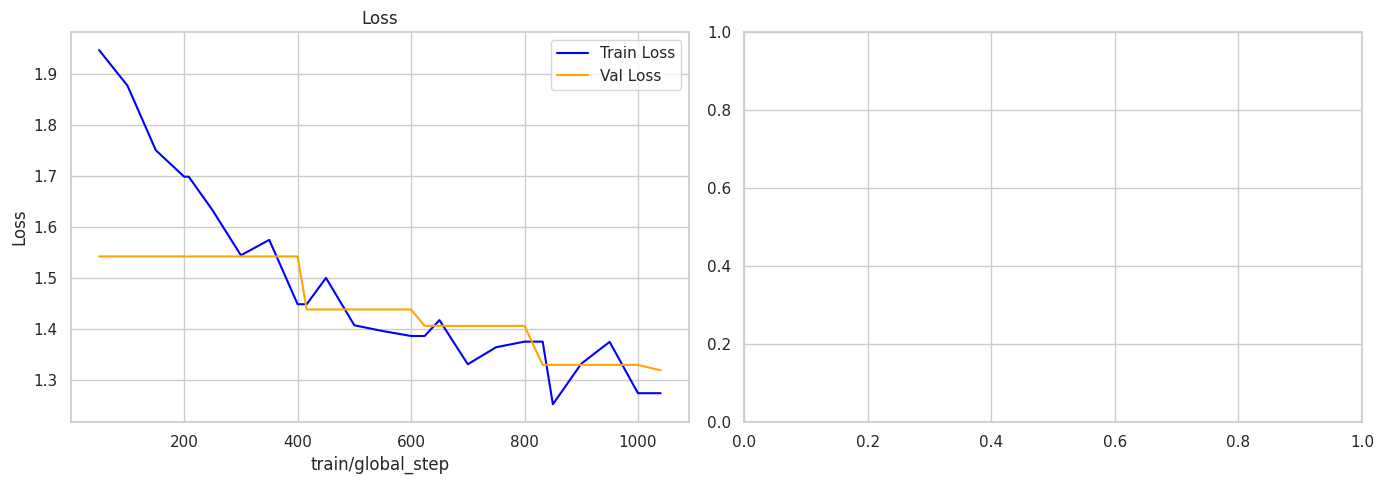

In [ ]:
plot_wandb_metrics(
    run_path='radyasrn-mipt/NLP-spring-2025/st0tpf7c',
    metric_keys=['eval/f1_negative', 'eval/f1_positive', 'eval/f1_macro_filtered'],
    title_suffix=None
)

We can see that training proceeded without problems, with loss decreasing almost identically on the training and validation sets.

Now we will train the model obtained after MLM pretraining on our task for $8$ epochs with `learning_rate=2e-5`, `weight_decay=0.01`, as we did before:

In [ ]:
wandb.init(project="NLP-spring-2025", name="rubert-mlm-finetuned-run-4")

model = AutoModelForSequenceClassification.from_pretrained(
    "./rubert-mlm-pretrained-model", num_labels=3
)
model.resize_token_embeddings(len(tokenizer))

training_args = TrainingArguments(
    output_dir="./results-rubert-mlm-finetune",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_steps=50,
    save_total_limit=1,
    metric_for_best_model="f1_macro_filtered",
    greater_is_better=True,
    load_best_model_at_end=True,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./rubert-mlm-pretrained-model and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/4261808699.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1 Negative,F1 Positive,F1 Macro Filtered
1,0.742600,0.605776,0.661269,0.010989,0.336129
2,0.547400,0.521188,0.699320,0.533589,0.616454
3,0.440200,0.495143,0.723684,0.633731,0.678708
4,0.367700,0.511565,0.787158,0.600368,0.693763
5,0.299700,0.533720,0.755280,0.605072,0.680176
6,0.240700,0.556986,0.773171,0.629174,0.701172
7,0.205000,0.574023,0.753512,0.629565,0.691539
8,0.185900,0.589109,0.748744,0.632689,0.690716


TrainOutput(global_step=416, training_loss=0.37049141354285753, metrics={'train_runtime': 724.1141, 'train_samples_per_second': 73.325, 'train_steps_per_second': 0.574, 'total_flos': 3492567506921472.0, 'train_loss': 0.37049141354285753, 'epoch': 8.0})

Then we will finish the run:

In [ ]:
wandb.finish()

And then save the model:

In [ ]:
trainer.save_model("./rubert-mlm-finetuned-model")
tokenizer.save_pretrained("./rubert-mlm-finetuned-model")

('./rubert-mlm-finetuned-model/tokenizer_config.json',
 './rubert-mlm-finetuned-model/special_tokens_map.json',
 './rubert-mlm-finetuned-model/vocab.txt',
 './rubert-mlm-finetuned-model/added_tokens.json',
 './rubert-mlm-finetuned-model/tokenizer.json')

Let's look at the training history:

/tmp/ipykernel_31/3774981854.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  history = history.fillna(method='ffill').fillna(method='bfill')


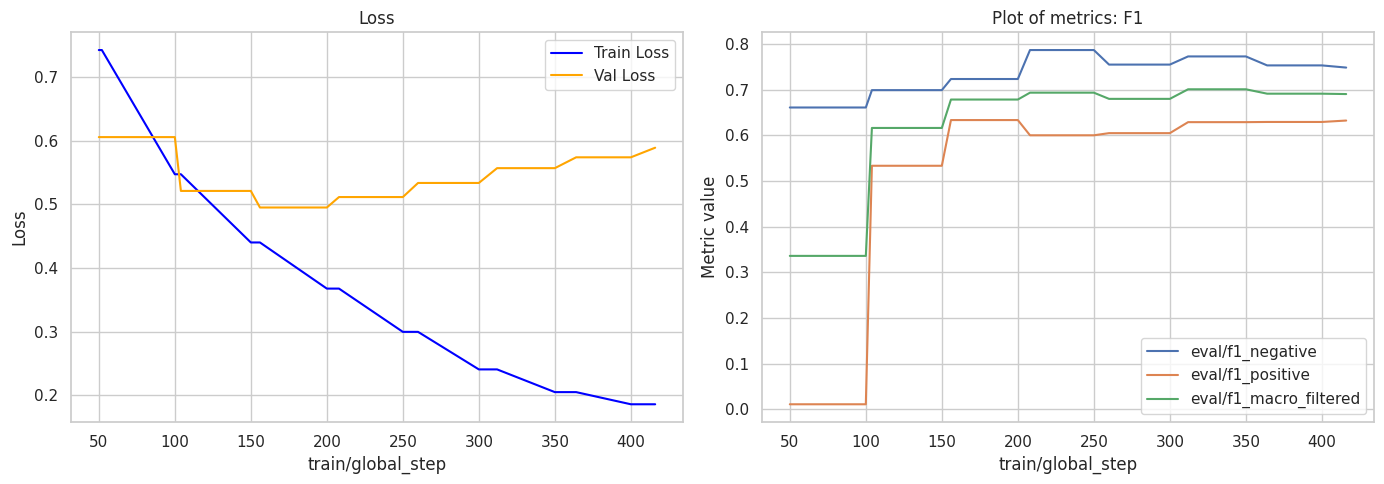

In [ ]:
plot_wandb_metrics(
    run_path='radyasrn-mipt/NLP-spring-2025/f6ie57fa',
    metric_keys=['eval/f1_negative', 'eval/f1_positive', 'eval/f1_macro_filtered'],
    title_suffix='F1'
)

We can see that the metrics plot is very similar to the metrics plot from the first model.

Let's look at some examples of predictions:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "./rubert-mlm-finetuned-model", num_labels=3
)
model.resize_token_embeddings(len(tokenizer))

metrics_after_mlm_pretrain = analyze_predictions(
    model=model,
    dataset=val_dataset,
    raw_df=val_df,
    text_column="sentence",
    label_column="label",
    entity_column="entity",
    batch_size=64,
    n_examples=5
)
metrics_after_mlm_pretrain

  0%|          | 0/45 [00:00<?, ?it/s]


Correct predictions:
- Text: Войны не будет: Трамп заинтересован в мирном разрешении кризиса c КНДР
  Entity: КНДР
  True label: 2, Prediction: 2

- Text: Победа ХАМАС дает неплохие шансы израильским радикалам - противникам мирного процесса на выборах в марте 2006 г.
  Entity: ХАМАС
  True label: 2, Prediction: 2

- Text: 22 марта 2015 года в московской больнице на 82-м году жизни умер писатель-сатирик Аркадий Арканов.
  Entity: Аркадий Арканов
  True label: 2, Prediction: 2

- Text: Свыше 28 последних лет вождь прилагает много усилий ради достижения освобождения Пелтиера и является членом Комитета защиты Леонарда Пелтиера.
  Entity: Леонарда Пелтиера
  True label: 2, Prediction: 2

- Text: Так, три года назад картину Дали нашли благодаря усилиям следователей в Нидерландах и уважению представителей местного криминала к искусству (оказалось, что кража предметов искусства, среди голландских воров – страшный проступок).
  Entity: Дали
  True label: 2, Prediction: 2


Wrong predictions:
-

/tmp/ipykernel_31/3206778358.py:45: RuntimeWarning: invalid value encountered in cast
  labels_np = labels.numpy().astype(int)


{'f1_negative': 0.0,
 'f1_positive': 0.08523461041756349,
 'f1_macro_filtered': 0.04261730520878174}

We see that MLM pre-training has slightly reduced quality compared to the baseline.

<a name="step-3-rubert-model-with-entity-tokens-pooling"></a>
<b><font size=4>**Step $3$</font></b> <b><font size=2>(RuBERT Model with Entity Tokens Pooling):**</font></b>

In this step, we will create a model that will be similar to the baseline, except for the last classification layer. We will not simply make a prediction on the `[CLS]` token, but rather obtain weights for entity tokens through a linear layer and softmax, calculate the weighted sum of embeddings, and then perform classification based on the resulting outcome.

First, let's write a function for tokenization:

In [ ]:
def tokenize(example):
    """
    Tokenizes the input text and creates a binary mask for entity tokens
    using torch. The mask is equal to 1 at the positions of tokens between [ENTITY] and [/ENTITY].

    :param example: dictionary with the field “input_text”
    :return: dictionary with input_ids, attention_mask, entity_mask
    """
    tokenized_data = tokenizer(
        example["input_text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
    input_ids_list = tokenized_data["input_ids"]

    entity_mask_tensor = torch.zeros(len(input_ids_list), dtype=torch.long)

    ent_start_token_id = tokenizer.convert_tokens_to_ids("[ENTITY]")
    ent_end_token_id = tokenizer.convert_tokens_to_ids("[/ENTITY]")

    try:
        entity_start_index = input_ids_list.index(ent_start_token_id) + 1
        entity_end_index = input_ids_list.index(ent_end_token_id)

        if entity_start_index < entity_end_index:
            entity_mask_tensor[entity_start_index:entity_end_index] = 1
    except ValueError:
        pass

    if entity_mask_tensor.sum() == 0 and len(input_ids_list) > 0:
        entity_mask_tensor[0] = 1

    tokenized_data["entity_mask"] = entity_mask_tensor
    return tokenized_data

Then we will create the datasets:

In [ ]:
train_dataset = Dataset.from_pandas(train_df[["input_text", "label"]])
val_dataset = Dataset.from_pandas(val_df[["input_text", "label"]])

train_dataset = train_dataset.map(tokenize).remove_columns(["input_text"])
val_dataset = val_dataset.map(tokenize).remove_columns(["input_text"])
train_dataset.set_format("torch")
val_dataset.set_format("torch")

Map:   0%|          | 0/6637 [00:00<?, ? examples/s]

Map:   0%|          | 0/2845 [00:00<?, ? examples/s]

We will run training, as in previous models, for $8$ epochs with `learning_rate=2e-5`, `weight_decay=0.01`:

In [ ]:
wandb.init(project="NLP-spring-2025", name="rubert-attention-pooling-run-20")

model = BertEntitySentimentClassifier(model_checkpoint, tokenizer, num_labels=3)

training_args = TrainingArguments(
    output_dir="./results-rubert-attention-pooling",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_steps=50,
    metric_for_best_model="f1_macro_filtered",
    greater_is_better=True,
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Then we will finish the run:

In [ ]:
wandb.finish()

And then save the model:

In [ ]:
trainer.save_model("./rubert-attention-pooling-model")
tokenizer.save_pretrained("./rubert-attention-pooling-model")

('./rubert-attention-pooling-model/tokenizer_config.json',
 './rubert-attention-pooling-model/special_tokens_map.json',
 './rubert-attention-pooling-model/vocab.txt',
 './rubert-attention-pooling-model/added_tokens.json',
 './rubert-attention-pooling-model/tokenizer.json')

Let's look at the training history:

/tmp/ipykernel_31/3774981854.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  history = history.fillna(method='ffill').fillna(method='bfill')


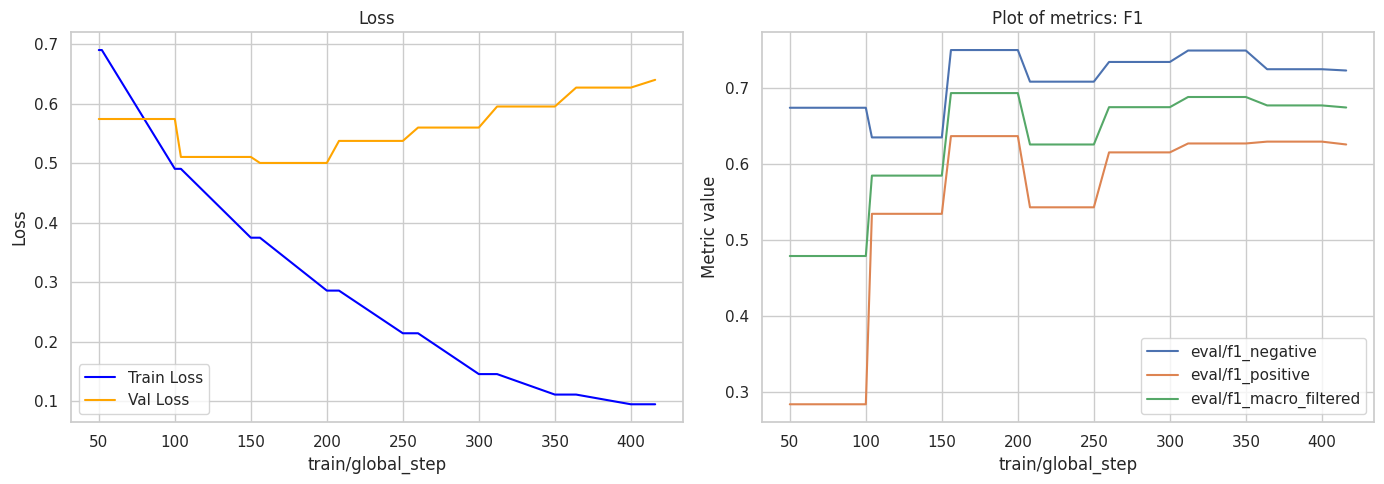

In [ ]:
plot_wandb_metrics(
    run_path='radyasrn-mipt/NLP-spring-2025/5i4sv8uy',
    metric_keys=['eval/f1_negative', 'eval/f1_positive', 'eval/f1_macro_filtered'],
    title_suffix='F1'
)

Now let's look at the prediction examples:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("./rubert-attention-pooling-model")

model = BertEntitySentimentClassifier(
    model_checkpoint="DeepPavlov/rubert-base-cased",
    tokenizer=tokenizer,
    num_labels=3
)

state_dict = load_file("./rubert-attention-pooling-model/model.safetensors")
model.load_state_dict(state_dict)

model.eval()
model.cuda()

metrics_after_attention_pooling = analyze_predictions(
    model=model,
    dataset=val_dataset,
    raw_df=val_df,
    text_column="sentence",
    label_column="label",
    entity_column="entity",
    batch_size=64,
    n_examples=5
)
metrics_after_attention_pooling

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/45 [00:00<?, ?it/s]


Correct predictions:
- Text: Итальянская пресса отмечает: ''«на протяжении долгой истории этих особых отношений Берлускони и Путин занимали различные государственные должности, но всегда находили повод для встреч: они советовались друг с другом, в их отношениях была гармония вне зависимости от официальных обязанностей или вызывающих подозрение личных мотивов»''.
  Entity: Берлускони
  True label: 2, Prediction: 2

- Text: Демидов высоко оценил качество изданного лейблом Геометрия релиза, заявил, что исполнил свою мечту — «писать альбомы, как романы» и что в песне «Живём в лесу» явлен мир, идеальный для хронопа.
  Entity: хронопа
  True label: 2, Prediction: 2

- Text: Лэнса Армстронга лишили всех побед на «Тур де Франс»
  Entity: Лэнса Армстронга
  True label: 2, Prediction: 2

- Text: Об этом 30 апреля 2018 года сообщается на сайте миссии НАТО «Решительная поддержка».
  Entity: Решительная поддержка
  True label: 2, Prediction: 2

- Text: В Москве начались съёмки художественного филь

/tmp/ipykernel_31/3206778358.py:45: RuntimeWarning: invalid value encountered in cast
  labels_np = labels.numpy().astype(int)


{'f1_negative': 0.0,
 'f1_positive': 0.07130434782608695,
 'f1_macro_filtered': 0.035652173913043476}

<a name="step-4-final-comparison-of-models"></a>
<b><font size=3>**Step $4$</font></b> <b><font size=2>(Final Comparison of Models):**</font></b>

In this step, we will look at the final results:

In [ ]:
records = [
    {"model": "baseline", **metrics_baseline},
    {"model": "mlm_pretrained", **metrics_after_mlm_pretrain},
    {"model": "attention_pooling", **metrics_after_attention_pooling},
]

records = pd.DataFrame(records)
records = records.round(2)
records

,model,f1_negative,f1_positive,f1_macro_filtered
0,baseline,0.77,0.67,0.72
1,mlm_pretrained,0.77,0.63,0.70
2,attention_pooling,0.73,0.62,0.68


* We can see that the quality of the models is almost the same. The baseline is the best, followed by the model after MLM pretraining, then the model with attention pooling.

* Most likely, the second model is of poorer quality because MLM pretraining is too different from our downstream task.

* The third model has worse quality, most likely because the `[CLS]` token of the first model contains much more information about the entity than any weighted sum of entity token representations, possibly due to mixing interference.